In [24]:
from bs4 import BeautifulSoup as BS
import pandas as pd, numpy as np
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
import time, re


In [64]:
site_scrapers={
    'target':{
        #specific top-level fields for a product from Target
        'product_data':
            {'product_title':"//h1[@data-test='product-title']",
            #'product_cost':"",
            'product_details':"//div[@data-test='productDetailTabs-itemDetailsTab']",
            'product_specs':"//div[@data-test='item-details-specifications']",
            'product_price':"//span[@class='styles__CurrentPriceFontSize-sc-1mh0sjm-1 kwKAiv']"
            },
# details = driver.find_element(by=By.XPATH,value="//div[@data-test='@web/site-top-of-funnel/ProductDetailCollapsible-Details']")
# specs = driver.find_element(by=By.XPATH,value="//div[@data-test='@web/site-top-of-funnel/ProductDetailCollapsible-Specifications']")

        #target has dynamic content; this allows us to expand the product details and specifications page
        'product_expand':{
            'product_details':"//div[@data-test='@web/site-top-of-funnel/ProductDetailCollapsible-Details']",
            'product_specs':"//div[@data-test='@web/site-top-of-funnel/ProductDetailCollapsible-Specifications']"
        },
        #this allows us to navigate within a product page to the reviews and customer feedback
        'navigation':{
            'feedback':"//a[@data-test='ratingCountLink']",
            'reviews':"//button[@data-test='totalReviewLink']",
            'expand':"//button[@class='styles__StyledBaseButtonInternal-sc-ysboml-0 styles__ButtonSecondary-sc-125aivg-0 brTHah bxLMor']" 
        },
        #these are the items we extract at the top level (e.g. for all reviews summary)
        'review_summary':[
            ('total_star_rating',"//div[@data-test='rating-value']"),
            ('total_star_votes',"//div[@data-test='rating-count']")            
        ],
        #this is the class and style of every block that contains a review
        'review_list':"//div[@class='styles__StyledRow-sc-wmoju4-0 jJAWfL styles__ReviewRow-sc-4u2mi2-1 hmboNn']",
        #this is the data we extract from each review.

        'review_data':{
            'review_header':('h4',{'data-test':'review-card--title'}),
            'reviewer_name':('span',{'data-test':'review-card--username'}),
            'review_content':('div',{'data-test':'review-card--text'}),
            'review_star_rating':('span',{'class':'utils__ScreenReaderOnly-sc-1b93ups-0 hMtWwx'}),
            'review_helpful_votes':('div',{'class':'h-text-sm h-margin-v-tight h-text-grayDark'}),
            'verified_purchaser':('span',{'data-test':'review-card--verified-purchaser'})
        }
    },
    'bestbuy':{
        'product_data':{
            'product_title':"//h1[@class:'heading-5 v-fw-regular']",
            'product_details':"//div[@class:'overflow-scroll-wrapper']",
            'product_specs':"//div[@class:'overflow-scroll-wrapper']"
        },
        'product_expand':{
            'product_desc':"//button:[@class=c-button-unstyled features-drawer-btn w-full flex justify-content-between align-items-center py-200]",
            'product_specs':"//button[@class='c-button c-button-outline c-button-md show-full-specs-btn col-xs-6']"
        },
        'navigation':{
            'reviews':"//a[@data-track='See All Customer Reviews']",
            'review_links':"//ul[@class='pagination ugc body-copy-lg']", #navigate to other pages.
        },
        'review_summary':[

        ],
        'review_data':{
            'review_header':('h4',{'class':'c-section-title review-title heading-5 v-fw-medium'}),
            'reviewer_name':('div',{'class':'ugc-author v-fw-medium body-copy-lg'}),
            'review_content':('div',{'class':'ugc-review-body'}),
            'review_star_rating':('p',{'class':'visually-hidden'}),
            'review_helpful_votes':('button',{'data-track':'Helpful'}),
            'verified_purchaser':('div',{'class':'verified-purchaser-mv-wrapper'}),
            'promo_consideration?':('div',{'class':'body-copy-sm pt-50'})
        }
    },
    'amazon':{
        'product_data':{

        },
        'product_expand':{
            
        },
        'navigation':{

        },
        'review_summary':[
            
        ],
        'review_data':{

        }
    }
}

#provide the list of specific products for which we will scrape data
# target_product_urls = [
# 'https://www.target.com/p/doritos-nacho-cheese-flavored-tortilla-chips-14-5oz/-/A-13319564?ref=tgt_adv_xsp&AFID=google&fndsrc=tgtao&DFA=71700000108139139&CPNG=PLA_Snacks%2BCandy%2BShopping_Local%7CSnacks%2BCandy_Ecomm_Food_Bev&adgroup=SC_Snacks%2BCandy&LID=700000001170770pgs&LNM=PRODUCT_GROUP&network=g&device=c&location=9028882&targetid=pla-566872943420&gad_source=1&gclid=CjwKCAiA_tuuBhAUEiwAvxkgTrVUgEoQxO7gDRv43EXIBS0LKEJIZzesWGUMd9JSJq7OybsxjUxfSxoCYmYQAvD_BwE&gclsrc=aw.ds',
# 'https://www.target.com/p/adjustable-storage-desk-black-room-essentials-8482/-/A-54364953'
# ]

prod_lookups = pd.read_excel('../data/Data Collection.xlsx',sheet_name='productDataCapture')
prod_data = pd.read_excel('../data/Data Collection.xlsx',sheet_name='productCollectionList')
target_product_urls = list(prod_lookups[(prod_lookups['site']=='target')&~(prod_lookups['URL'].isna())]['URL'])
target_product_urls
#open a web browser
driver = webdriver.Edge()

In [65]:
#lists to collect records/data for each link
product_records=[]
review_records=[]
#iterate through the target list of products
for target in target_product_urls:
    curr_product = target #doing this to save time after restructuring code
    #dictionary to store data on the current product
    product_record = {'url':curr_product}
    #navigate to the page
    driver.get(curr_product)
    #wait for page to load
    time.sleep(3)
    #select dynamic fields and expand them for the product
    for k,v in site_scrapers['target']['product_expand'].items():
        time.sleep(0.5)
        e = None
        while e is None:
            e = driver.find_element(By.XPATH,value=v)
            time.sleep(0.1)
        e.click()

    #iterate through the fields we want to pull for product data
    for k,v in site_scrapers['target']['product_data'].items():
        data = driver.find_element(by=By.XPATH,value=v)
        product_record[k] = data.text
    #print("finished top level")

    #navigate to the top of the page to find the button we're looking for
    driver.find_element(By.TAG_NAME,value='body').send_keys(Keys.CONTROL+Keys.HOME)

    #navigate to the reviews
    for k,v in site_scrapers['target']['navigation'].items():
        time.sleep(1)
        #print(k,v)
        #print("driver.find_element({})".format(v))
        try:
            c = driver.find_element(By.XPATH,value=v)
        except: 
            c = None 
        if c:
            if k != 'expand':
                time.sleep(1)
                c.click()
                #time.sleep(0.5)
            else:
                #get the summarized review data (x.x/5 stars, number of votes)
                for r in site_scrapers['target']['review_summary']:
                    product_record[r[0]] = driver.find_element(By.XPATH,value=r[1]).text
                #expand out to all reviews - keep expanding until we can't.
                while c:
                    c.click()
                    time.sleep(0.25)
                    try:
                        c = driver.find_element(By.XPATH,value=v)
                    except:
                        c = None

    #append the product record to the list 
    product_records.append(product_record)
    # #build a list of review records.
    # review_records = []

    #get the container that has all the reviews in it
    #review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledRow-sc-wmoju4-0 jJAWfL styles__ReviewRow-sc-4u2mi2-1 hmboNn']")
    review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width']")
    for review in review_elements:
        #create a dictionary for the current review
        review_record = {'url':curr_product}
        #beautiful soup seems to work better than selenium for parsing here.
        current = BS(review.get_attribute('innerHTML'))
        for k1,v1 in site_scrapers['target']['review_data'].items(): #my_map.items():#site_scrapers['target']['review_data']:
            if k1 not in ['review_star_rating','review_helpful_votes']:
                val = current.find(v1[0],v1[1])
                if val:
                    review_record[k1] = val.getText()
                else:
                    review_record[k1] = None
                #review_record[k1] = current.find(v1[0],v1[1]).getText()
            else:
                if k1 == 'review_star_rating':
                    #use regex to find the star rating for the review
                    review_record[k1] = re.findall('(.) ?(?=out of 5 stars)',review.get_attribute('innerHTML'))[0]
                else: 
                    #use regex to get the number of votes that said this one was useful.
                    m = re.findall('([1-9]+) ?(?=guests found)',review.get_attribute('innerHTML'))
                    #sometimes reviews aren't voted as useful.  If they're not, mark them as zero.
                    if m:
                        review_record[k1] = m[0]
                    else:
                        review_record[k1] = 0
        #append the current review to the list of reviews.
        review_records.append(dict.copy(review_record))
        #print(review_record)


driver.find_element(//a[@data-test='ratingCountLink'])
driver.find_element(//button[@data-test='totalReviewLink'])
driver.find_element(//button[@class='styles__StyledBaseButtonInternal-sc-ysboml-0 styles__ButtonSecondary-sc-125aivg-0 brTHah bxLMor'])
driver.find_element(//a[@data-test='ratingCountLink'])
driver.find_element(//button[@data-test='totalReviewLink'])
driver.find_element(//button[@class='styles__StyledBaseButtonInternal-sc-ysboml-0 styles__ButtonSecondary-sc-125aivg-0 brTHah bxLMor'])
driver.find_element(//a[@data-test='ratingCountLink'])
driver.find_element(//button[@data-test='totalReviewLink'])
driver.find_element(//button[@class='styles__StyledBaseButtonInternal-sc-ysboml-0 styles__ButtonSecondary-sc-125aivg-0 brTHah bxLMor'])
driver.find_element(//a[@data-test='ratingCountLink'])
driver.find_element(//button[@data-test='totalReviewLink'])
driver.find_element(//button[@class='styles__StyledBaseButtonInternal-sc-ysboml-0 styles__ButtonSecondary-sc-125aivg-0 brTHah bxLMor

In [50]:
driver.find_element(By.XPATH,"//span[@class='styles__CurrentPriceFontSize-sc-1mh0sjm-1 kwKAiv']")

<selenium.webdriver.remote.webelement.WebElement (session="3ff2dee6e97d7ad7f19e38db76e0377c", element="f.0AD1D152CB1A07B4BD43F304AC145528.d.B1DC0834F1871A8DD91F3AA8D04964C5.e.2093")>

In [67]:
review_elements = driver.find_elements(By.XPATH,"//div[@class='styles__StyledDiv-sc-4u2mi2-6 fByBFT h-full-width']")
review_elements

[<selenium.webdriver.remote.webelement.WebElement (session="4b58147b3c89907723f14fea0120b527", element="f.2F55958910D55C70BB143C71865E3712.d.3EE59C130DEC98D848E08B20348D2BE2.e.7094")>]

In [63]:
x = BS(review_elements[4].get_attribute('innerHTML')).find('span',{'data-test':'review-card--verified-purchaser'})
if x:
    print("verified")
else:
    print("not")

not


In [1]:
products = pd.DataFrame(product_records)
reviews = pd.DataFrame(review_records)
products.to_csv('../data/target_products.csv',index=False)
reviews.to_csv('../data/target_reviews.csv',index=False)

NameError: name 'pd' is not defined

In [69]:
products.head()

,url,product_title,product_details,product_specs,product_price,total_star_rating,total_star_votes
0,https://www.target.com/p/apple-iphone-14/-/A-8...,Apple iPhone 14,Highlights\n6.1-inch Super Retina XDR display¹...,Dimensions (Overall): 5.78 Inches (H) x 2.82 I...,Price Varies,4.4,447 star ratings
1,https://www.target.com/p/samsung-galaxy-s22-ul...,Samsung Galaxy S22 Ultra 5G Unlocked (128GB) S...,Highlights\n8K video - the highest resolution ...,Dimensions (Overall): 6.43 Inches (H) x 3.06 I...,"$1,199.99",4.6,8016 star ratings
2,https://www.target.com/p/hp-deskjet-2755e-wire...,HP DeskJet 2755e Wireless All-In-One Color Pri...,Highlights\nBest for home printing\nAll-in-one...,Dimensions (Overall): 6.06 Inches (H) x 16.7 I...,$49.99,3.8,1642 star ratings
3,https://www.target.com/p/jbl-charge-5-portable...,JBL Charge 5 Portable Bluetooth Waterproof Spe...,Highlights\nTarget Certified Refurbished speak...,Dimensions (Overall): 3.76 Inches (H) x 3.67 I...,$107.99,NaN,NaN
4,https://www.target.com/p/microsoft-365-persona...,Microsoft 365 Personal 12-Month Subscription (...,Highlights\nFor one person\nUse on Windows PCs...,Video Game Genre: Home/Office Software\nFormat...,$69.99,3.0,26 star ratings


In [70]:
len(review_records)

3416

In [41]:
len(reviews)
#reviews = pd.read_csv('../data/target_reviews.csv')

3416

In [73]:
reviews.head()

,url,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchaser
0,https://www.target.com/p/apple-iphone-14/-/A-8...,Help with the nightmare situation.,J Fosko,When I got the phone we did not want the phone...,3,0,None
1,https://www.target.com/p/apple-iphone-14/-/A-8...,Loving it!,Nanner74,I am new to iPhones but I am loving the easy u...,5,0,None
2,https://www.target.com/p/apple-iphone-14/-/A-8...,Nice phone,Brandi R,My daughter really likes her new phone.,5,0,None
3,https://www.target.com/p/apple-iphone-14/-/A-8...,Apple Iphone 14 purchase,Larry Justin,The Apple Iphone 14 is well worth the price. E...,5,0,None
4,https://www.target.com/p/apple-iphone-14/-/A-8...,Happy,Momo3boys,It’s pretty good no different then the 13,5,0,None


In [29]:
import pandas as pd, numpy as np
reviews = pd.read_csv('../data/target_reviews.csv')
products = pd.read_csv('../data/target_products.csv')

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords

In [30]:
import textblob
test_blob = textblob.TextBlob(products.loc[0]['product_details'])

In [31]:
products['description_subjectivity'] = None

In [32]:
stop = set(stopwords.words("english"))
for i,row in products.iterrows():
    blob = textblob.TextBlob(row['product_details'] + "\n" + row['product_specs'])
    # tokens = set(blob.words)
    # blob = textblob.TextBlob(''.join(tokens-stop))
    subj = blob.subjectivity
    #print(subj)
    row['description_subjectivity'] = float(subj)
    products.loc[i] = row

#products
    
products['total_star_votes'] = products['total_star_votes'].str.replace(' star ratings','')
products['total_star_votes'] = products['total_star_votes'].astype(float)
products

products['product_price'] = products['product_price'].str.replace('\$|,','',regex=True)
#products[products['product_price']=='Price Varies']['product_price'] = 0
#products['product_price'] = products['product_price'].astype(float)
products

C:\Users\pconn\AppData\Local\Temp\ipykernel_19980\3799214314.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products[products['product_price']=='Price Varies']['product_price'] = 0


,url,product_title,product_details,product_specs,product_price,total_star_rating,total_star_votes,description_subjectivity
0,https://www.target.com/p/apple-iphone-14/-/A-8...,Apple iPhone 14,Highlights\r\n6.1-inch Super Retina XDR displa...,Dimensions (Overall): 5.78 Inches (H) x 2.82 I...,Price Varies,4.4,447.0,0.437937
1,https://www.target.com/p/samsung-galaxy-s22-ul...,Samsung Galaxy S22 Ultra 5G Unlocked (128GB) S...,Highlights\r\n8K video - the highest resolutio...,Dimensions (Overall): 6.43 Inches (H) x 3.06 I...,1199.99,4.6,8016.0,0.478984
2,https://www.target.com/p/hp-deskjet-2755e-wire...,HP DeskJet 2755e Wireless All-In-One Color Pri...,Highlights\r\nBest for home printing\r\nAll-in...,Dimensions (Overall): 6.06 Inches (H) x 16.7 I...,49.99,3.8,1642.0,0.555611
3,https://www.target.com/p/jbl-charge-5-portable...,JBL Charge 5 Portable Bluetooth Waterproof Spe...,Highlights\r\nTarget Certified Refurbished spe...,Dimensions (Overall): 3.76 Inches (H) x 3.67 I...,107.99,NaN,NaN,0.290826
4,https://www.target.com/p/microsoft-365-persona...,Microsoft 365 Personal 12-Month Subscription (...,Highlights\r\nFor one person\r\nUse on Windows...,Video Game Genre: Home/Office Software\r\nForm...,69.99,3.0,26.0,0.492037
5,https://www.target.com/p/turbotax-2023-deluxe-...,TurboTax 2023 Deluxe Federal and State Tax Sof...,Highlights\r\nTurboTax® Deluxe Federal + State...,Video Game Genre: Tax Preparational Software\r...,59.99,4.4,10794.0,0.658157
6,https://www.target.com/p/hamilton-beach-4-slic...,Hamilton Beach 4 slice Toaster 24782,Highlights\r\nEVENLY TOASTS BOTH SIDES OF SING...,Dimensions (Overall): 7.6 Inches (H) x 11 Inch...,59.99,NaN,NaN,0.449512
7,https://www.target.com/p/razor-24v-mx350-dirt-...,Razor 24V MX350 Dirt Rocket Electric Powered R...,Highlights\r\nAuthentic motocross frame geomet...,Dimensions (Overall): 28.0 Inches (H) x 24.0 I...,329.99,4.1,429.0,0.523889
8,https://www.target.com/p/lg-65-34-class-4k-uhd...,"LG 65"" Class 4K UHD 2160p Smart OLED TV - OLED...",Highlights\r\nBrighter picture powered by Brig...,Dimensions (Overall): 32.5 Inches (H) x 56.7 I...,1699.99,4.7,639.0,0.435398
9,https://www.target.com/p/ge-jes1460dsbb-1-4-cu...,GE JES1460DSBB 1.4 Cu. Ft. Black Counter Top M...,"Highlights\r\n1.4 Cu. Ft. Capacity, 1100W Of P...",Dimensions (Overall): 14.0 inches (H) x 18.0 i...,190.10,4.4,3080.0,0.344769


In [5]:
products.info()
products['description_subjectivity'] = products['description_subjectivity'].astype(float)
products.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       14 non-null     object 
 1   product_title             14 non-null     object 
 2   product_details           14 non-null     object 
 3   product_specs             14 non-null     object 
 4   product_price             14 non-null     object 
 5   total_star_rating         11 non-null     float64
 6   total_star_votes          11 non-null     object 
 7   description_subjectivity  14 non-null     object 
dtypes: float64(1), object(7)
memory usage: 1.0+ KB


,count,mean,std,min,25%,50%,75%,max
total_star_rating,11.0,4.327273,0.531208,3.000000,4.250000,4.400000,4.700000,4.800000
description_subjectivity,14.0,0.499391,0.106496,0.290826,0.440831,0.507963,0.548835,0.681818


In [6]:
reviews[['review_subjectivity','review_polarity']] = None,None
for i,row in reviews.iterrows():
    #include the header in the summary
    #s = row['review_header'] + row['review_content']
    blob = textblob.TextBlob(row['review_content'])
    row[['review_subjectivity','review_polarity']] = float(blob.subjectivity),float(blob.polarity)
    reviews.loc[i] = row



In [7]:
reviews['review_length'] = reviews['review_content'].str.len()

reviews

,url,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchaser,review_subjectivity,review_polarity,review_length
0,https://www.target.com/p/apple-iphone-14/-/A-8...,Help with the nightmare situation.,J Fosko,When I got the phone we did not want the phone...,3,0,NaN,0.75,0.375,104
1,https://www.target.com/p/apple-iphone-14/-/A-8...,Loving it!,Nanner74,I am new to iPhones but I am loving the easy u...,5,0,NaN,0.667576,0.333939,218
2,https://www.target.com/p/apple-iphone-14/-/A-8...,Nice phone,Brandi R,My daughter really likes her new phone.,5,0,NaN,0.327273,0.168182,39
3,https://www.target.com/p/apple-iphone-14/-/A-8...,Apple Iphone 14 purchase,Larry Justin,The Apple Iphone 14 is well worth the price. E...,5,0,NaN,0.39697,0.242424,83
4,https://www.target.com/p/apple-iphone-14/-/A-8...,Happy,Momo3boys,It’s pretty good no different then the 13,5,0,NaN,0.733333,0.316667,41
...,...,...,...,...,...,...,...,...,...,...
3411,https://www.target.com/p/crest-cavity-38-tarta...,Great job on teeth,Shelley310,Great product. Makes teeth and mouth feel grea...,5,0,NaN,0.56,0.56,112
3412,https://www.target.com/p/crest-cavity-38-tarta...,Exactly what I want,Ginger628,This product is great and does everything I ne...,5,0,NaN,0.75,0.8,57
3413,https://www.target.com/p/crest-cavity-38-tarta...,Perfect,Michy,"I highly recommend this toothpaste , makes my ...",5,0,NaN,0.601667,0.29,78
3414,https://www.target.com/p/crest-cavity-38-tarta...,great product,Lgreco,we love this product make our teeth feel great...,5,0,NaN,0.6375,0.541667,104


In [31]:
x = reviews.groupby('url',as_index=False).agg({
    'review_helpful_votes':'mean',
    'review_subjectivity':'mean',
    'review_polarity':'mean',
    'review_length':'mean'
}
)

x.merge(right=products,how='left',on='url')[
    ['product_title','url','review_helpful_votes','review_subjectivity',
     'review_polarity','review_length','description_subjectivity','total_star_rating'
     ]
]

,product_title,url,review_helpful_votes,review_subjectivity,review_polarity,review_length,description_subjectivity,total_star_rating
0,Apple iPhone 14,https://www.target.com/p/apple-iphone-14/-/A-8...,0.031863,0.578940,0.335787,96.058824,0.437937,4.4
1,"Crest Cavity & Tartar Protection Toothpaste, B...",https://www.target.com/p/crest-cavity-38-tarta...,0.532847,0.547487,0.293993,174.978102,0.545629,4.7
2,Doritos Nacho Cheese Flavored Tortilla Chips -...,https://www.target.com/p/doritos-nacho-cheese-...,1.938095,0.551695,0.393941,74.252381,0.681818,4.8
3,GE JES1460DSBB 1.4 Cu. Ft. Black Counter Top M...,https://www.target.com/p/ge-jes1460dsbb-1-4-cu...,0.019608,0.518098,0.287269,176.698529,0.344769,4.4
4,HP DeskJet 2755e Wireless All-In-One Color Pri...,https://www.target.com/p/hp-deskjet-2755e-wire...,2.259804,0.581468,0.222523,302.210784,0.555611,3.8
5,JBL Charge 5 Portable Bluetooth Waterproof Spe...,https://www.target.com/p/jbl-charge-5-portable...,0.000000,0.300000,0.150000,148.000000,0.290826,NaN
6,"LG 65"" Class 4K UHD 2160p Smart OLED TV - OLED...",https://www.target.com/p/lg-65-34-class-4k-uhd...,0.029412,0.617655,0.393312,258.061275,0.435398,4.7
7,Microsoft 365 Personal 12-Month Subscription (...,https://www.target.com/p/microsoft-365-persona...,6.200000,0.614028,0.144092,124.066667,0.492037,3.0
8,OXO POP 3pc Plastic Food Storage Container Set...,https://www.target.com/p/oxo-pop-3pc-plastic-f...,5.000000,0.750000,0.500000,146.000000,0.549213,NaN
9,Razor 24V MX350 Dirt Rocket Electric Powered R...,https://www.target.com/p/razor-24v-mx350-dirt-...,7.607143,0.490321,0.250930,195.403061,0.523889,4.1


In [8]:
reviews['review_polarity'] = reviews['review_polarity'].astype(float)
reviews['review_subjectivity'] = reviews['review_subjectivity'].astype(float)
reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
review_star_rating,3416.0,4.406030,1.167625,1.0,4.0000,5.000000,5.0,5.0
review_helpful_votes,3416.0,0.885246,3.163713,0.0,0.0000,0.000000,0.0,63.0
review_subjectivity,3416.0,0.556650,0.233181,0.0,0.4500,0.578619,0.7,1.0
review_polarity,3416.0,0.308787,0.296761,-1.0,0.1141,0.311111,0.5,1.0
review_length,3416.0,198.348361,231.562732,10.0,71.0000,129.500000,230.0,2467.0


reviews['']

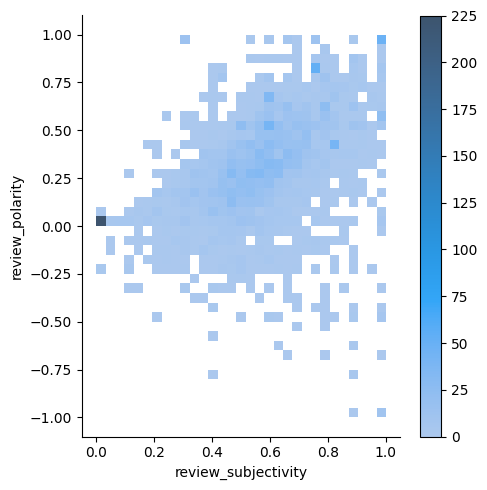

In [9]:
import matplotlib.pyplot as plt, seaborn as sns 

sns.displot(
    data=reviews,
    x='review_subjectivity',y='review_polarity',cbar=True
)


Looks like the review subjectivity and objectivity intersection is where it's neutral polarity and not subjective.  Doesn't seem to be a strong correlation beetween subjectivity and polarity just on glance.

In [10]:
subj_docs = [(sent,'subj') for sent in subjectivity.sents(categories='subj')]
obj_docs = []